In [1]:
import os
import subprocess

# For processing
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For data split and imbalanced data
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn import preprocessing

# For Random Forest testing
import h2o

# For config parsing
import configparser
config = configparser.ConfigParser()
config.read_file(open('config/config-azure.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
sales

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0


In [3]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

,CodigoDC,Cliente,Marca,Cupo
0,297601,8410,29,9
1,297601,9337,29,9
2,309843,7404,40,16
3,309874,4017,40,16
4,309910,6316,40,16
...,...,...,...,...
27763,646815,2144,29,9
27764,646976,28,29,9
27765,647188,10023,29,9
27766,648099,10193,29,9


In [4]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')

In [5]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1
1,9,2009-03-03,4,21,9,2,3,1
2,15,2009-03-03,4,21,9,2,3,0
3,37,2009-03-03,4,21,16,2,3,1
4,43,2009-03-03,4,21,9,2,3,0
...,...,...,...,...,...,...,...,...
15064,15040,2019-03-07,1,16,9,2,1,0
15065,15043,2019-03-07,1,20,15,2,2,1
15066,15052,2019-03-09,3,7,10,2,2,0
15067,15065,2019-03-16,4,21,9,2,2,0


In [6]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'

sales_exec_promos

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,CodigoDC,ES_PROMO
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0,NaN,NaN
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0,NaN,NaN
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0,NaN,NaN
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0,NaN,NaN
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0,NaN,NaN
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0,NaN,NaN


In [7]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
final_df = df[['Cliente', 'Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']].fillna({
    'ES_PROMO': 'NO',
    'Cupo': df['Cupo'].mode()[0]
})

final_df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,NO
1,1,18,16.0,4,21,12,1,1,1,NO
2,1,2,6.0,4,21,12,1,1,1,NO
3,1,37,34.0,4,21,12,1,1,1,NO
4,1,2,16.0,4,21,12,1,1,1,NO
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,NO
1894248,15069,44,32.0,4,14,9,2,1,0,NO
1894249,15069,44,32.0,4,14,9,2,1,0,NO
1894250,15069,2,6.0,4,14,9,2,1,0,NO


### Preparar Data de Test y Train

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 34 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_tjander_x9chjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.89 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


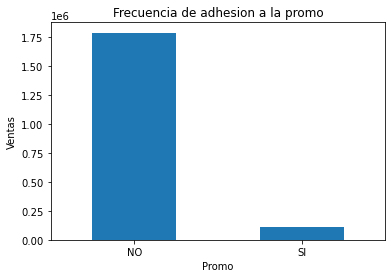

In [8]:
h2o.init(nthreads = -1, max_mem_size = '16g')

trgt_index = final_df.columns.tolist().index('ES_PROMO')

x_to_split, y_to_split = final_df.iloc[:, 0:trgt_index].values, final_df.iloc[:, trgt_index].values

x_train_st, x_test, y_train_st, y_test = train_test_split(x_to_split,
                                                    y_to_split)

count_class = pd.value_counts(final_df['ES_PROMO'], sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()



/anaconda/envs/py37_default/lib/python3.7/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


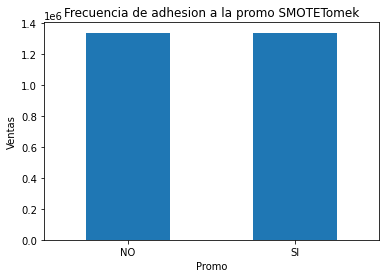

In [10]:
os_us = SMOTETomek(1)
x_train, y_train = os_us.fit_sample(x_train_st, y_train_st)

count_class = pd.value_counts(y_train, sort = True)
count_class.plot(kind = 'bar', rot = 0)
plt.title('Frecuencia de adhesion a la promo SMOTETomek')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [11]:
cols = final_df.columns.tolist()
del cols[trgt_index]
x_train_df, y_train_df = pd.DataFrame(x_train, columns = cols), pd.DataFrame(y_train, columns = ['ES_PROMO'])
df_train = pd.concat([x_train_df, y_train_df], axis = 1)
df_train

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,8715.0,44.0,16.0,3.0,30.0,18.0,1.0,2.0,0.0,NO
1,11037.0,40.0,19.0,3.0,9.0,9.0,2.0,3.0,0.0,NO
2,11880.0,44.0,10.0,4.0,15.0,18.0,2.0,2.0,1.0,NO
3,2961.0,23.0,26.0,3.0,7.0,18.0,2.0,3.0,1.0,NO
4,14130.0,37.0,16.0,1.0,18.0,18.0,2.0,4.0,0.0,NO
...,...,...,...,...,...,...,...,...,...,...
2677167,2515.0,39.0,20.0,1.0,18.0,9.0,2.0,3.0,0.0,SI
2677168,10784.0,40.0,16.0,5.0,11.0,16.0,2.0,3.0,1.0,SI
2677169,13663.0,39.0,20.0,1.0,18.0,1.0,2.0,2.0,0.0,SI
2677170,11551.0,39.0,20.0,1.0,18.0,16.0,2.0,3.0,0.0,SI


In [12]:
x_test_df, y_test_df = pd.DataFrame(x_test, columns = cols), pd.DataFrame(y_test, columns = ['ES_PROMO'])
df_test = pd.concat([x_test_df, y_test_df], axis = 1)

In [13]:
h2o_train = h2o.H2OFrame(df_train)
h2o_test  = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
m = h2o.estimators.H2ORandomForestEstimator(nfolds=10,
                                            max_depth=20,
                                            ntrees=50)

In [16]:
predictor_cols = ['Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']
target_col     = 'ES_PROMO'
m.train(training_frame = h2o_train,
        x = predictor_cols,
        y = target_col)

drf Model Build progress: |███████████████████████████████████████████████| 100%


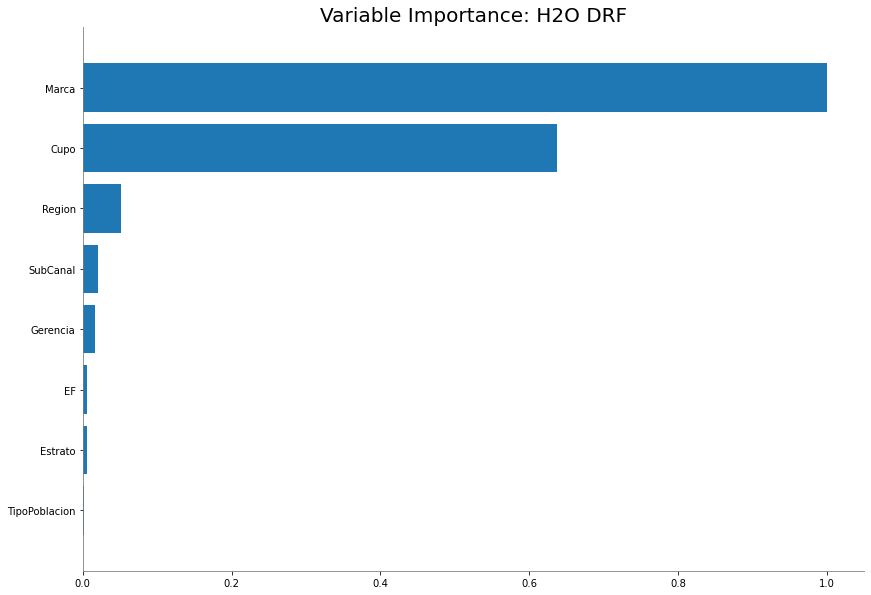

In [17]:
m.varimp_plot()

In [18]:
m.model_performance(h2o_test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.013767248344724288
RMSE: 0.11733391813420486
LogLoss: 0.05624280034946821
Mean Per-Class Error: 0.009029378513958575
AUC: 0.99675061788005
AUCPR: 0.9289488189731129
Gini: 0.9935012357601001

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9047536623250177: 


,,NO,SI,Error,Rate
0,NO,441093.0,4850.0,0.0109,(4850.0/445943.0)
1,SI,733.0,26887.0,0.0265,(733.0/27620.0)
2,Total,441826.0,31737.0,0.0118,(5583.0/473563.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.904754,0.905942,71.0
1,max f2,0.719599,0.952167,110.0
2,max f0point5,0.960539,0.879546,41.0
3,max accuracy,0.920902,0.988236,65.0
4,max precision,0.994797,0.990385,0.0
5,max recall,0.042452,1.000000,324.0
6,max specificity,0.994797,0.999993,0.0
7,max absolute_mcc,0.904754,0.902157,71.0
8,max min_per_class_accuracy,0.783766,0.987521,96.0
9,max mean_per_class_accuracy,0.587035,0.990971,140.0



Gains/Lift Table: Avg response rate:  5.83 %, avg score:  8.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010007,9.897844e-01,16.555923,16.555923,0.965605,9.917572e-01,0.965605,0.991757,0.165677,0.165677,1555.592293,1555.592293,0.165312
1,2,0.020063,9.847450e-01,16.342740,16.449074,0.953171,9.873879e-01,0.959373,0.989567,0.164337,0.330014,1534.274034,1544.907360,0.329149
2,3,0.030000,9.819547e-01,15.374982,16.093286,0.896728,9.837474e-01,0.938622,0.987639,0.152788,0.482802,1437.498204,1509.328597,0.480847
3,4,0.040009,9.759453e-01,14.530400,15.702296,0.847468,9.791234e-01,0.915818,0.985509,0.145438,0.628240,1353.040030,1470.229647,0.624664
4,5,0.050186,9.679716e-01,14.117859,15.381022,0.823407,9.720222e-01,0.897080,0.982774,0.143664,0.771904,1311.785854,1438.102211,0.766419
5,6,0.100069,1.004622e-01,4.571836,9.992738,0.266647,5.133800e-01,0.582815,0.748785,0.228059,0.999964,357.183604,899.273786,0.955631
6,7,0.150003,3.834641e-02,0.000725,6.666521,0.000042,6.629149e-02,0.388817,0.521592,0.000036,1.000000,-99.927493,566.652120,0.902642
7,8,0.202702,1.853492e-02,0.000000,4.933359,0.000000,2.775847e-02,0.287732,0.393205,0.000000,1.000000,-100.000000,393.335903,0.846680
8,9,0.300175,9.399889e-03,0.000000,3.331385,0.000000,1.449042e-02,0.194299,0.270228,0.000000,1.000000,-100.000000,233.138471,0.743169
9,10,0.400226,4.002142e-04,0.000000,2.498591,0.000000,2.259514e-03,0.145727,0.203240,0.000000,1.000000,-100.000000,149.859127,0.636922


In [19]:
cli_active_promo = active_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
columns = final_df.columns.tolist()
index_target = columns.index('ES_PROMO')
del columns[index_target]

cli_active_promo = cli_active_promo[columns]
cli_active_promo.head(1)


h2o_predict_df = h2o.H2OFrame(cli_active_promo)

p = m.predict(h2o_predict_df)
p

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


predict,NO,SI
SI,0.298477,0.701523
NO,0.7482,0.2518
NO,0.467079,0.532921
SI,0.0100232,0.989977
SI,0.0167259,0.983274
SI,0.00474023,0.99526
SI,0.00929258,0.990707
SI,0.00793503,0.992065
SI,0.012167,0.987833
SI,0.0325236,0.967476


### Sanitizar output

In [20]:
predicted_df = h2o.as_list(p)
predicted_df = predicted_df.rename(columns = {'SI': 'Ejecuto_Promo'})

pred_merged_df = pd.concat([active_promos,predicted_df],axis=1)

# resultado_final
pred_no_dupes_df = pred_merged_df.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
pred_no_dupes_df
result = pred_no_dupes_df[['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo']].set_index('Cliente')
result


,Marca,Cupo,Ejecuto_Promo
Cliente,,,
3213,29,9,0.701523
3795,29,9,0.251800
11816,29,9,0.532921
8444,40,16,0.989977
8488,40,16,0.983274
...,...,...,...
15040,39,20,0.730044
14840,40,16,0.948325
1844,29,9,0.040321


In [22]:
import tempfile
output_filename = "{}/{}".format(tempfile.gettempdir(), "random_forest_balanced.csv")

print("GUARDANDO EL OUTPUT EN {} ...".format(output_filename))
result
result.to_csv(output_filename)

GUARDANDO EL OUTPUT EN /tmp/random_forest_balanced.csv ...
